In [1]:
import sys
import torch
import os
from torch.nn import functional as F
sys.path.insert(0, '../src')
from clean_text import text_preprocessing_pipeline
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
model_name = 'roberta-base'
MAX_LEN = 200

In [6]:
def set_palette():
    # custom palette
    custom_colors = ["#fe6053", "#b3637c", "#333030", '#FF6400']
    custom_palette = sns.color_palette(custom_colors)
    sns.set(font_scale=1.4)
    sns.set_palette(custom_palette)

# PCA on a summary vector from roberta

In [7]:
df = pd.read_csv(os.getcwd() + '/../data/perfect_dataset.csv')
df = df.sample(frac=0.1).reset_index(drop=True)
# clean the text
df['text'] = df['text'].apply(text_preprocessing_pipeline)
# get distinct tags
target_cols = df['tag'].unique()
# one hot encode the tags
encoder = OneHotEncoder()
label = encoder.fit_transform(df[['tag']]).toarray()
# append one hot encoded label to the dataframe with distinct tags as columns
df = pd.concat([df, pd.DataFrame(label, columns=target_cols)], axis=1)
# reset the index
df.reset_index(drop=True, inplace=True)

/home/john/DataspellProjects/AnalyzingLyricsByAI/eda/../src/clean_text.py:24: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        # self.l2 = torch.nn.Dropout(0.3)
        # self.l1 = torch.nn.Linear(768, 256)
        self.fc = torch.nn.Linear(768,5)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        #features = F.relu(self.l1(features))
        # output_2 = self.l2(output_1)
        output = F.softmax(self.fc(features), dim=1)
        return output

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = BERTClass()
model.load_state_dict(torch.load(os.getcwd() + '/../model/model4.bin'))
model.to(device)

# from the model get only the features from the forward pass
def get_features(text):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device)
    _, features = model.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
    return features.cpu().detach().numpy()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
df['features'] = df['text'].apply(get_features)
df.features = df.features.apply(lambda x: x.reshape(-1))
pca = PCA(n_components=2)
pca = pca.fit(df['features'].to_list())
df['pca'] = df['features'].apply(lambda x: pca.transform([x])[0])
df['pca_x'] = df['pca'].apply(lambda x: x[0])
df['pca_y'] = df['pca'].apply(lambda x: x[1])

In [38]:
# custom palette
custom_colors = ["#fe6053", "#b3637c", "#35D4A4", "#333030", "#f9a03f"]
custom_palette = sns.color_palette(custom_colors)
sns.set(font_scale=1.4)
sns.set_palette(custom_palette)

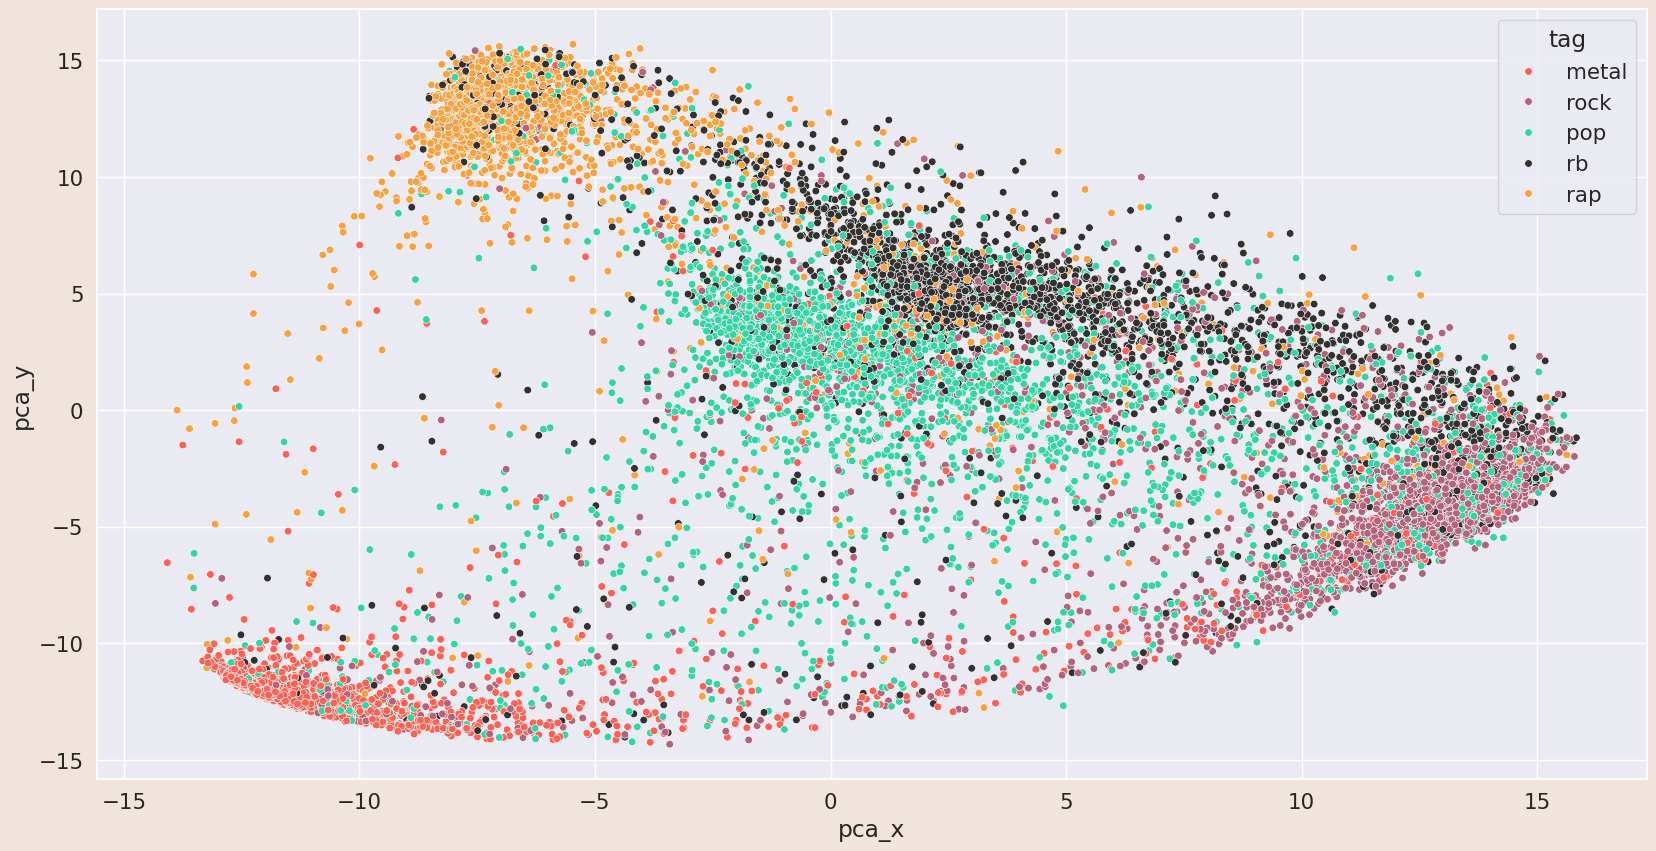

In [39]:
# Plot the data
plt.figure(figsize=(20, 10))
# set background color
plt.gcf().set_facecolor('#f0e4dd')


sns.scatterplot(x='pca_x', y='pca_y', hue='tag', data=df, s=30)
plt.savefig('pca.png')

# Accuracy | Final dataset | Classical ML + roberta

In [4]:
metrics = pd.read_csv('metrics.csv')
metrics = metrics.drop(columns=['Unnamed: 0'])
metrics.head()

,model,vectorization,accuracy
0,SGD,tf-idf,0.625286
1,LogReg,tf-idf,0.631714
2,KNN,tf-idf,0.292714
3,RandFor,tf-idf,0.614000
4,GradBoost,tf-idf,0.610000


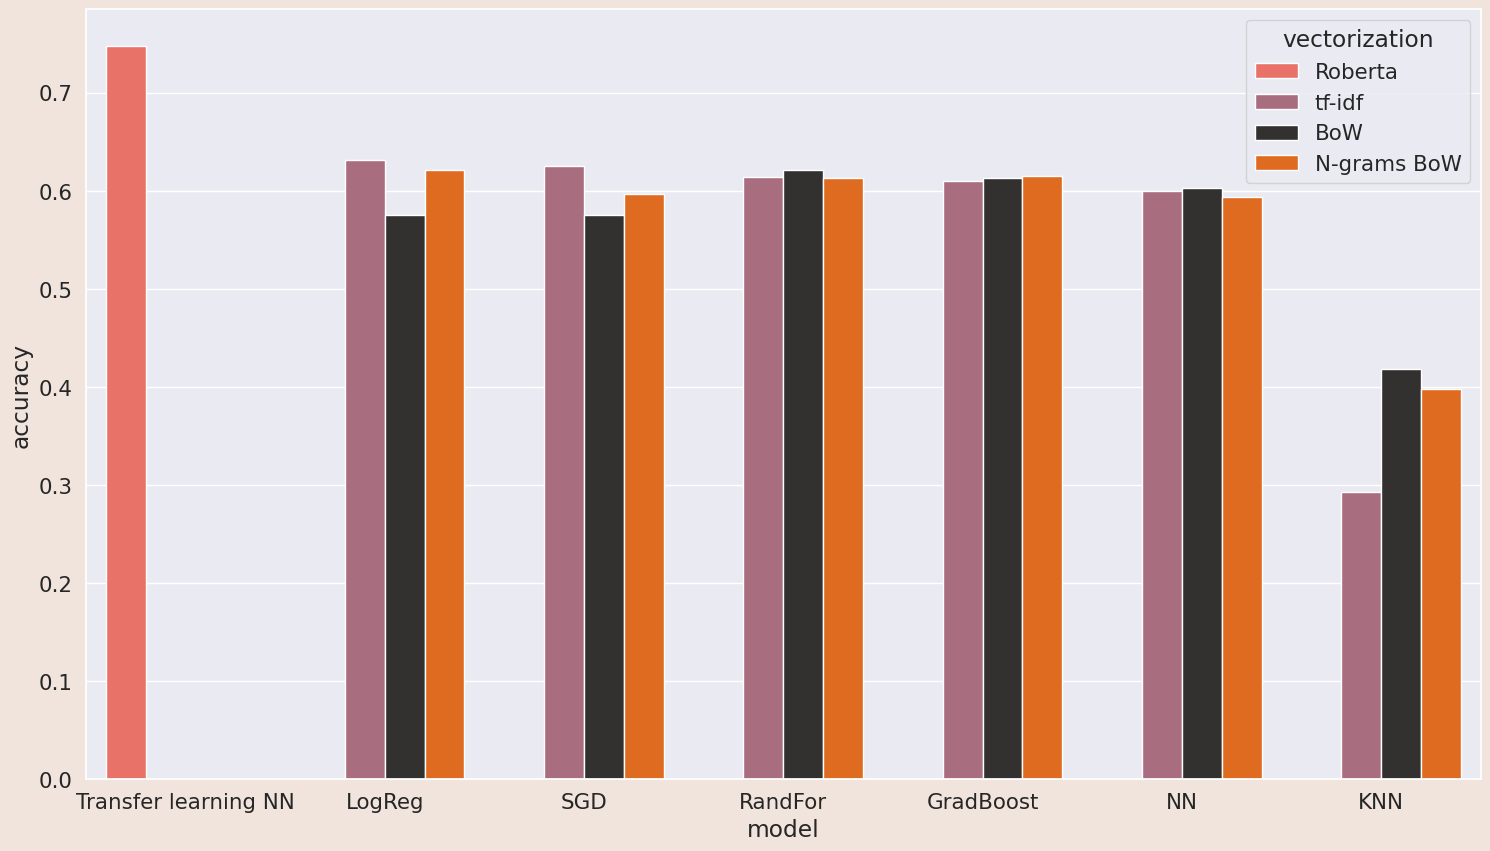

In [7]:
metrics_melted = metrics.sort_values(by='accuracy', ascending=False)

set_palette()

plt.figure(figsize=(18, 10))
sns.barplot(x='model', y='accuracy', hue='vectorization', data=metrics_melted)
# set background color
plt.gcf().set_facecolor('#f0e4dd')
plt.savefig('metrics.png')
plt.show()